In [1]:
import matplotlib.pyplot as plt
import cmdstanpy
import pandas as pd
import numpy  as np
import pickle
from   math import pi

SAVE = lambda data, filepath: pickle.dump(data, open(filepath + ".pkl", "wb"))   # save file
LOAD = lambda filepath:       pickle.load(open(filepath       + ".pkl", "rb"))   # read file

# control parameter
is_warmup      = True
is_old_harm    = False
scaling_factor = 100
dataset        = 3
isOnCVVM       = False


# limits
xi_lower   = 0.1   / scaling_factor if is_warmup else 5       / scaling_factor
xi_upper   = 1.9   / scaling_factor if is_warmup else 32      / scaling_factor
s_xi_lower = 0.01  / scaling_factor if is_warmup else 0.1     / scaling_factor
s_xi_upper = 4.0   / scaling_factor if is_warmup else 5.0     / scaling_factor
mu_lower   = 0.5   / scaling_factor if is_warmup else 16      / scaling_factor
mu_upper   = 1.5   / scaling_factor if is_warmup else 24      / scaling_factor
t0_lower   = 0.9   / scaling_factor if is_warmup else 23      / scaling_factor
t0_upper   = 1.1   / scaling_factor if is_warmup else 23.4    / scaling_factor
om_f_lower = 0.56  * scaling_factor if is_warmup else 0.00006 * scaling_factor   # 2 * pi / 100k
om_f_upper = 0.58  * scaling_factor if is_warmup else 1       * scaling_factor   # 2 * pi / 5
#
A_lower    = 2                      if is_warmup else 0.001
A_upper    = 18                     if is_warmup else 5
om_lower   = 0.56  * scaling_factor if is_warmup else 0.0001  * scaling_factor   # 2 * pi / 50k
om_upper   = 0.58  * scaling_factor if is_warmup else 0.03    * scaling_factor   # 2 * pi / 200
s_y_lower  = 0.1                    if is_warmup else 0.05
s_y_upper  = 8                      if is_warmup else 2
#
mu_mean    = 1     / scaling_factor if is_warmup else 20      / scaling_factor
mu_std     = 0.25  / scaling_factor if is_warmup else 0.5     / scaling_factor
s_xi_mean  = 1     / scaling_factor if is_warmup else 0.46    / scaling_factor
s_xi_std   = 0.5   / scaling_factor if is_warmup else 0.25    / scaling_factor
xi1_mean   = 1     / scaling_factor if is_warmup else 20.5    / scaling_factor
xi1_std    = 0.1   / scaling_factor if is_warmup else 1       / scaling_factor
s_y_mean   = 1                      if is_warmup else 0.44
s_y_std    = 1                      if is_warmup else 0.4


data_file      = "~/data/syntheticData.xlsx" if is_warmup else "~/data/YES_data.xlsx"
harm_file      =          "~/data/None.xlsx" if is_warmup else "~/data/YES_10k_year.xlsx"
old_harm_file  =          "~/data/None.xlsx" if is_warmup else "~/data/OLD_harmonics.xlsx"
harm_test_file =          "~/data/None.xlsx" if is_warmup else "~/data/Borneo Stalagmite 26.05.25.xlsx"
stan_file      = "~/STAN/model.stan"
warm_stan_file = "~/STAN/model_warmup.stan"
iter_s         =  50000 if is_warmup else 1000
iter_w         = 150000 if is_warmup else 1000
cs             =      1 if is_warmup else 1
parl_cs        =      1 if is_warmup else 1

if not isOnCVVM:
    data_file      = "~/Scrivania/MOD B/esercizi/github/Project/data" + data_file[6:]
    harm_file      = "~/Scrivania/MOD B/esercizi/github/Project/data" + harm_file[6:]
    old_harm_file  = "~/Scrivania/MOD B/esercizi/github/Project/data" + old_harm_file[6:]
    harm_test_file = "~/Scrivania/MOD B/esercizi/github/Project/data" + harm_test_file[6:]
    stan_file      = "~/Scrivania/MOD B/esercizi/github/Project/STAN" + stan_file[6:]
    warm_stan_file = "~/Scrivania/MOD B/esercizi/github/Project/STAN" + warm_stan_file[6:]
    iter_s         = 150
    iter_w         = 150
    cs             = 1
    parl_cs        = 1
######################

# compile model
if not is_warmup:
    model = cmdstanpy.CmdStanModel(stan_file   = stan_file,
                                   cpp_options = {"STAN_THREADS" : True})
else:
    model = cmdstanpy.CmdStanModel(stan_file   = warm_stan_file,
                                   cpp_options = {"STAN_THREADS" : True})
#####


if is_warmup:
    # read data
    data         = pd.read_excel(data_file, skiprows = 1)
    data         = data.iloc[1:, [0, 1, 3, 4, 6, 7]]
    data.columns = ["t", "y", "t", "y", "t", "y"]
    data         = data.dropna()
    data.reset_index(drop = True, inplace = True)
    data.index   = data.index + 1
    data1        = data.iloc[:, [0, 1]]
    data2        = data.iloc[:, [2, 3]]
    data3        = data.iloc[:, [4, 5]]
    n            = data.shape[0]
    #
    if   dataset == 1:
        y = data1.iloc[:, [1]].values.reshape(n)
    elif dataset == 2:
        y = data2.iloc[:, [1]].values.reshape(n)
    elif dataset == 3:
        y = data3.iloc[:, [1]].values.reshape(n)
    #####
    #
    # select data
    data = {
            "n"           : n,
            "y"           : y,
            "t0_lower"    : t0_lower,
            "t0_upper"    : t0_upper,
            "om_f_lower"  : om_f_lower,
            "om_f_upper"  : om_f_upper,
            "t0"          : 1 / scaling_factor,
            "omega_fixed" : scaling_factor * 2 * pi / 11,
            "A_ini"       : 10.0,
            "sigma_A"     : 1.0,
            "phi_ini"     : 2.0,
            "sigma_phi"   : 0.3,
            "xi_lower"    : xi_lower,
            "xi_upper"    : xi_upper,
            "s_xi_lower"  : s_xi_lower,
            "s_xi_upper"  : s_xi_upper,
            "mu_lower"    : mu_lower,
            "mu_upper"    : mu_upper,
            "A_lower"     : A_lower,
            "A_upper"     : A_upper,
            "om_lower"    : om_lower,
            "om_upper"    : om_upper,
            "s_y_lower"   : s_y_lower,
            "s_y_upper"   : s_y_upper,
            "mu_mean"     : mu_mean,
            "mu_std"      : mu_std,
            "s_xi_mean"   : s_xi_mean,
            "s_xi_std"    : s_xi_std,
            "xi1_mean"    : xi1_mean,
            "xi1_std"     : xi1_std,
            "s_y_mean"    : s_y_mean,
            "s_y_std"     : s_y_std
    }
    #
    # starting points
    init = {
        'A'        : 10.0,
        'phi'      : 2.0,
        'sigma_y'  : 0.15,
        'tau'      : 1.0,
        'mu'       : 1.0  / scaling_factor,
        'sigma_xi' : 0.03 / scaling_factor,
        'xi'       : [1   / scaling_factor] * (n - 1)
    }
    #
    #
else:
    # read data
    data         = pd.read_excel(data_file, skiprows = 0)
    data         = data.iloc[4:, [1, 2]]
    data.columns = ["age", "y"]
    data["age"]  = data["age"] + 55
    data         = data[data["age"] < 10000 + 55]
    data["y"]    = data["y"] - data["y"].mean()
    data.reset_index(drop = True, inplace = True)
    data.index   = data.index + 1
    n            = data.shape[0]
    #
    # read harmonics
    if is_old_harm:
        harm         = pd.read_excel(old_harm_file, skiprows = 0)
        harm         = harm.iloc[:, [1,2,3,4,5,6]]
        harm.columns = list(harm.iloc[3])
        harm         = harm.iloc[4:]
        harm.reset_index(drop = True, inplace = True)
        harm.index   = harm.index + 1
        harm.loc[1, "sigma_phase"] = harm["Phase"].iloc[0] * (harm["sigma_phase"] / harm["Phase"]).iloc[0:21].mean()
        #
        # make parameters
        harm["omega"]       = scaling_factor * 2 * pi / harm["Period"]
        harm["sigma_omega"] = 1 / (harm["Period"] - harm["sigma_period"])
        harm["sigma_omega"] = harm["sigma_omega"] - (1 / (harm["Period"] + harm["sigma_period"]))
        harm["sigma_omega"] = scaling_factor * pi * harm["sigma_omega"]
        harm                = harm.iloc[:, 2:]
        harm["A"]           = harm["Amplitude"]
        harm["sigma_A"]     = harm["sigma_amplitude"]
        harm                = harm.iloc[:, 2:]
        harm["Phi"]         = harm["Phase"]
        harm["sigma_phi"]   = harm["sigma_phase"]
        harm                = harm.iloc[:, 2:]
        #
        # make order
        harm              = pd.concat([harm.iloc[8:9], harm.iloc[:8], harm.iloc[9:]])
        harm.reset_index(drop = True, inplace = True)
        harm.index        = harm.index + 1
        l                 = harm.shape[0]
    else:
        harm         = pd.read_excel(harm_file, skiprows = 0)
        harm.index   = harm.index + 1
        #
        # make parameters
        harm["omega"]       = scaling_factor * 2 * pi / harm["period"]
        harm["sigma_omega"] = 1 / (harm["period"] - harm["s_period"])
        harm["sigma_omega"] = harm["sigma_omega"] - (1 / (harm["period"] + harm["s_period"]))
        harm["sigma_omega"] = scaling_factor * pi * harm["sigma_omega"]
        harm                = harm.iloc[:, 2:]
        harm["A"]           = harm["amplitude"]
        harm["sigma_A"]     = harm["s_amplitude"]
        harm                = harm.iloc[:, 2:]
        harm["Phi"]         = harm["phi"]
        harm["sigma_phi"]   = harm["s_phi"]
        harm                = harm.iloc[:, 2:]
        #
        # select omega_fixed
        harm_test           = pd.read_excel(harm_test_file, skiprows = 3)
        harm_test           = harm_test.iloc[[1,2,3,4,13,14,15], [0,1,2,3,4,5]]
        harm_test.reset_index(drop = True, inplace = True)
        harm_test.index     = harm_test.index + 1
        harm_test["omega"]  = scaling_factor * 2 * pi / harm_test["Period"]
        harm_test           = harm_test.iloc[:, 6:]
        items               = list(harm_test.values.reshape(harm_test.shape[0]))
        selection           = set()
        for item in items:
            relative_error = 100 * abs(harm["omega"] - item) / item
            tmp_selection  = harm["omega"][relative_error <= 1]
            selection      = selection | set(tmp_selection)
        #####
        selection = np.array(list(selection))
        selection = harm.index[harm["omega"] == selection[0]].to_list()[0] - 1
        #
        # make order
        f          = harm.iloc[selection       : (selection + 1)]
        b          = harm.iloc[                : selection]
        a          = harm.iloc[(selection + 1) : ]
        harm       = pd.concat([f, b, a])
        harm.reset_index(drop = True, inplace = True)
        harm.index = harm.index + 1
        l          = harm.shape[0]
    #####
    #
    # make xis
    ts  = data.iloc[:, [0]].values.reshape(n) / scaling_factor
    xis = ts[1:] - ts[:-1]
    # np.insert(np.cumsum(xis) + ts[0], 0, ts[0])
    #
    #
    # select data
    data = {
            "n"           : n,
            "l"           : l,
            "y"           : data.iloc[:, [1]].values.reshape(n),
            "t0_lower"    : t0_lower,
            "t0_upper"    : t0_upper,
            "om_f_lower"  : om_f_lower,
            "om_f_upper"  : om_f_upper,
            "t0"          : ts[0],
            "omega_fixed" : harm["omega"].iloc[0],
            "omega_ini"   : harm["omega"].iloc[1:].values.reshape(l - 1),
            "sigma_omega" : harm["sigma_omega"].iloc[1:].values.reshape(l - 1),
            "A_ini"       : harm["A"].values.reshape(l),
            "sigma_A"     : harm["sigma_A"].values.reshape(l),
            "phi_ini"     : harm["Phi"].values.reshape(l),
            "sigma_phi"   : harm["sigma_phi"].values.reshape(l),
            "xi_lower"    : xi_lower,
            "xi_upper"    : xi_upper,
            "s_xi_lower"  : s_xi_lower,
            "s_xi_upper"  : s_xi_upper,
            "mu_lower"    : mu_lower,
            "mu_upper"    : mu_upper,
            "A_lower"     : A_lower,
            "A_upper"     : A_upper,
            "om_lower"    : om_lower,
            "om_upper"    : om_upper,
            "s_y_lower"   : s_y_lower,
            "s_y_upper"   : s_y_upper,
            "mu_mean"     : mu_mean,
            "mu_std"      : mu_std,
            "s_xi_mean"   : s_xi_mean,
            "s_xi_std"    : s_xi_std,
            "xi1_mean"    : xi1_mean,
            "xi1_std"     : xi1_std,
            "s_y_mean"    : s_y_mean,
            "s_y_std"     : s_y_std
    }
    #
    # starting points
    init = {
        "A"        : harm["A"].values.reshape(l),
        "phi"      : harm["Phi"].values.reshape(l),
        "omega"    : harm["omega"].iloc[1:].values.reshape(l - 1),
        "sigma_y"  : 0.5,
        "tau"      : 1.0,
        "mu"       : 20  / scaling_factor,
        "sigma_xi" : 0.5 / scaling_factor,
        "xi"       : xis
    }
    #
    #
#####

In [2]:
res3 = LOAD("res3")

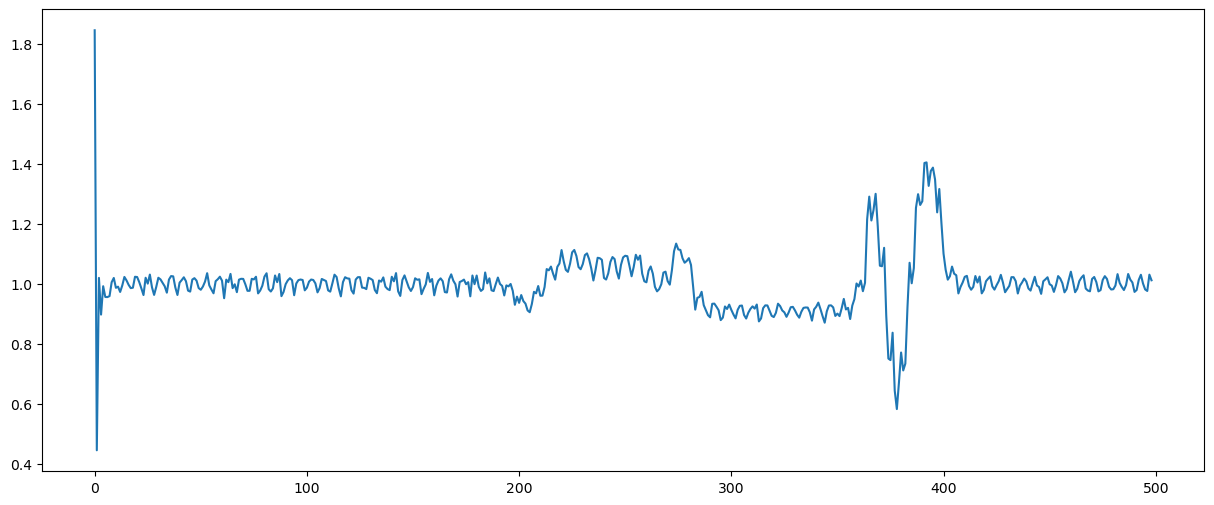

In [4]:
plt.figure(figsize = (15, 6))
plt.plot(res3.stan_variable('xi').mean(0))